# Pfand multi class classification

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from random import randint
from itertools import product
from sklearn.cluster import KMeans
import seaborn as sns
from tensorflow.keras.utils import image_dataset_from_directory
from PIL import Image
import os
import shutil

from google.colab import drive
import glob

## Mounting Google Drive

In [2]:
# Mounting drive
drive.mount('/content/drive')
# Viewing the data in the folder present from the drive
!ls "/content/drive/My Drive/PFAND_CLASSIFIER"

# copying preprocessed data from Google drive
!cp -r '/content/drive/My Drive/PFAND_CLASSIFIER/data_pfand' data 

# # importing custom functions
# !cp -r '/content/drive/My Drive/PFAND_CLASSIFIER/my_functions.py' my_functions.py
# from my_functions import *

Mounted at /content/drive
data_pfand  Pfand_classification.ipynb


## Dataset Preparation

### Train - validation - test split 

In [3]:
def readSamplesPathsAndLabels(categories, src_dir):
    """TODO
    """
    samples_pathfiles = []
    labels = []


    for label in categories:
        new_pathfiles = os.listdir(f'{src_dir}/{label}')
        samples_pathfiles += new_pathfiles

        new_labels = [label for i in range(len(new_pathfiles))]
        labels += new_labels

    return samples_pathfiles, labels

def datasetSplit(src_dir,
                 target_dir,
                 split_dirs_names=["train", "test"],
                 test_set_size=0.1):
    """
    """
    makeDirectory(target_dir)
    categories = os.listdir(src_dir)

    makeDirectory(f"{target_dir}/{split_dirs_names[0]}")
    makeDirectory(f"{target_dir}/{split_dirs_names[1]}")


    samples_pathfiles, labels = readSamplesPathsAndLabels(categories, src_dir)
    full_dataset_size = len(labels)
    shuffled_samples, shuffled_labels = shuffle(samples_pathfiles, labels)
    
    # smaller dataset
    split_index = int(test_set_size * full_dataset_size)
    small_dataset_paths = shuffled_samples[0:split_index]
    small_dataset_labels = shuffled_labels[0:split_index]
    # bigger dataset
    big_dataset_paths = shuffled_samples[split_index:]
    big_dataset_labels = shuffled_labels[split_index:]

    for split_dir in split_dirs_names:
        makeDirectory(f"{target_dir}/{split_dir}")
        for category in categories:
            makeDirectory(f"{target_dir}/{split_dir}/{category}")

    
    i = 0
    for dataset, dataset_labels in zip([small_dataset_paths, big_dataset_paths], [small_dataset_labels, big_dataset_labels]):
        for sample, label in zip(dataset, dataset_labels):
            dst_path = f"./{target_dir}/{split_dirs_names[i]}/{label}/"
            src_path = f"./{src_dir}/{label}/{sample}"
            shutil.move(src_path, dst_path)
        i +=1

def makeDirectory(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

In [4]:
# Train-test split 
datasetSplit(src_dir="./data",
             target_dir='./splitted_data',
             split_dirs_names=["test", "train_full" ],
             test_set_size=0.2
             )

# Train validation split
datasetSplit(src_dir='./splitted_data/train_full',
             target_dir='./splitted_data',
             split_dirs_names=["validation", "train"],
             test_set_size=0.15
             )

## Reading datasets

In [5]:
dataset_train = image_dataset_from_directory('./splitted_data/train', batch_size=32)
dataset_val = image_dataset_from_directory('./splitted_data/validation', batch_size=32)
dataset_test = image_dataset_from_directory('./splitted_data/test', batch_size=32)

Found 466 files belonging to 4 classes.
Found 82 files belonging to 4 classes.
Found 137 files belonging to 4 classes.


In [6]:
for data_batch, labels_batch in dataset_train:
    print("data batch shape:", data_batch.shape)
    img_shape = data_batch.shape[1:]
    print("labels batch shape:", labels_batch.shape)
    print(labels_batch)
    break
print(f"image_shape: {img_shape}")

data batch shape: (32, 256, 256, 3)
labels batch shape: (32,)
tf.Tensor([2 3 1 0 2 3 0 1 1 2 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 2 2 2 0 1 3 3], shape=(32,), dtype=int32)
image_shape: (256, 256, 3)


## One hot encoding labels

In [7]:
def ohEncodeDataset(dataset):
    """
    """
    for data_batch, labels_batch in dataset:
        depth = int(max(labels_batch)+1)
        break

    oh_dataset = dataset.map(lambda x, y: (x, tf.one_hot(y, depth=depth)))

    return oh_dataset

In [8]:
dataset_train = ohEncodeDataset(dataset_train)
dataset_val = ohEncodeDataset(dataset_val)
dataset_test = ohEncodeDataset(dataset_test)

## Test model

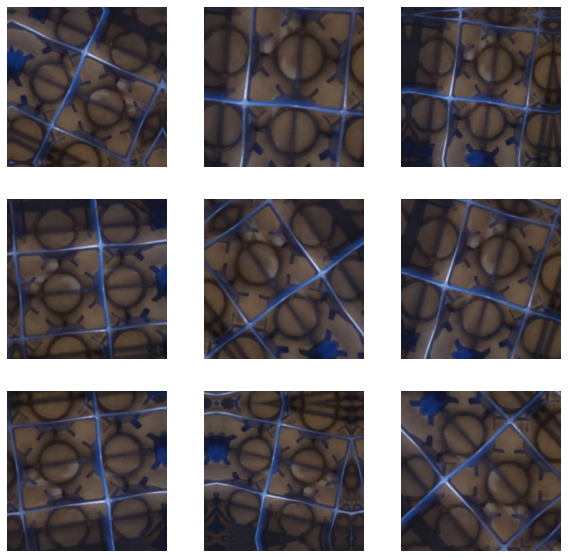

In [11]:
data_augmentation = keras.Sequential(
    [
     layers.RandomFlip(),
     layers.RandomRotation(1),
     layers.RandomZoom(0.2),
    #  layers.RandomBrightness(0.25)
     ], name='data_augmentation'
)

plt.figure(figsize=(10, 10))
for images, _ in dataset_train.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [12]:
inputs = keras.Input(shape=img_shape)
# data augmentation
x = data_augmentation(inputs)
# Rescaling to 0-1 range
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(4, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 256, 256, 3)      0         
 al)                                                             
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496 

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
history = model.fit(dataset_train,
                    epochs=18,
                    validation_data=dataset_val)

Epoch 1/18
 4/15 [=======>......................] - ETA: 1:02 - loss: 0.6753 - accuracy: 0.3203

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## test evaluation

In [ ]:
test_loss, test_acc = model.evaluate(dataset_test)
print(f"Test accuracy: {test_acc:.3f}")

5/5 [==============================] - 1s 91ms/step - loss: 0.1372 - accuracy: 0.9343
Test accuracy: 0.934
